In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('synthetic_ml_dataset.csv')

# Display first few rows
df.head()

,Age,Income,Education_Level,Marital_Status,Defaulted
0,21.735793,37167.329630,High School,Divorced,0
1,42.527021,40687.321711,High School,Single,0
2,29.529047,330497.864135,High School,Married,0
3,36.635733,62253.076700,High School,Married,0
4,30.651742,66498.574264,High School,Single,0


In [3]:
# Shape
print("Shape:", df.shape)

# Column names
print("Columns:", df.columns.tolist())

# Data types and summary
print("\nData Types:\n", df.dtypes)
print("\nSummary Statistics:\n", df.describe(include='all'))

Shape: (250, 5)
Columns: ['Age', 'Income', 'Education_Level', 'Marital_Status', 'Defaulted']

Data Types:
 Age                float64
Income             float64
Education_Level     object
Marital_Status      object
Defaulted            int64
dtype: object

Summary Statistics:
                Age         Income Education_Level Marital_Status   Defaulted
count   238.000000     238.000000             238            243  250.000000
unique         NaN            NaN               4              3         NaN
top            NaN            NaN       Bachelors        Married         NaN
freq           NaN            NaN              98            105         NaN
mean     33.543722   56866.820457             NaN            NaN    0.160000
std      10.100447   44917.446367             NaN            NaN    0.367341
min       1.115719    7906.743358             NaN            NaN    0.000000
25%      27.234608   40904.528394             NaN            NaN    0.000000
50%      34.075268   49920.90

In [4]:
# Check missing values
print("Missing values:\n", df.isnull().sum())

# Impute numeric features
num_imputer = SimpleImputer(strategy='mean')
df[['Age', 'Income']] = num_imputer.fit_transform(df[['Age', 'Income']])

# Impute categorical features with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
df[['Education_Level', 'Marital_Status']] = cat_imputer.fit_transform(df[['Education_Level', 'Marital_Status']])

# Verify
df.isnull().sum()

Missing values:
 Age                12
Income             12
Education_Level    12
Marital_Status      7
Defaulted           0
dtype: int64


Age                0
Income             0
Education_Level    0
Marital_Status     0
Defaulted          0
dtype: int64

In [5]:
# Encode ordinal categorical variable (Education)
education_order = ['High School', 'Bachelors', 'Masters', 'PhD']
df['Education_Level'] = pd.Categorical(df['Education_Level'], categories=education_order, ordered=True)
df['Education_Level'] = df['Education_Level'].cat.codes

# One-hot encode nominal categorical variable (Marital_Status)
df = pd.get_dummies(df, columns=['Marital_Status'], drop_first=True)

df.head()

,Age,Income,Education_Level,Defaulted,Marital_Status_Married,Marital_Status_Single
0,21.735793,37167.329630,0,0,False,False
1,42.527021,40687.321711,0,0,False,True
2,29.529047,330497.864135,0,0,True,False
3,36.635733,62253.076700,0,0,True,False
4,30.651742,66498.574264,0,0,False,True


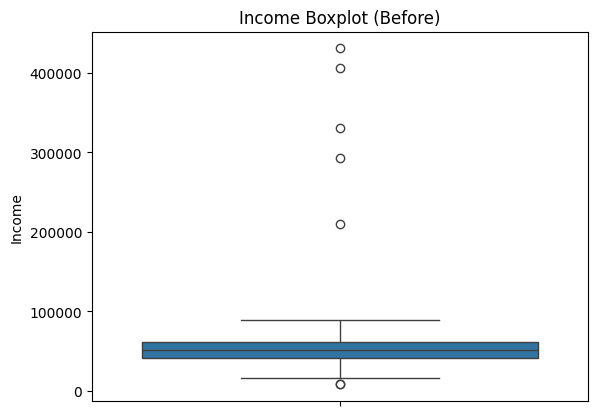

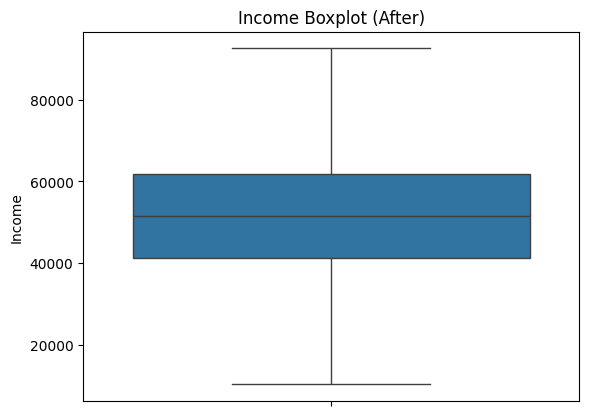

In [6]:
# Boxplot before removing outliers
sns.boxplot(df['Income'])
plt.title("Income Boxplot (Before)")
plt.show()

# Detect outliers using IQR
Q1 = df['Income'].quantile(0.25)
Q3 = df['Income'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap outliers
df['Income'] = np.where(df['Income'] > upper_bound, upper_bound, 
                        np.where(df['Income'] < lower_bound, lower_bound, df['Income']))

# Boxplot after handling outliers
sns.boxplot(df['Income'])
plt.title("Income Boxplot (After)")
plt.show()

In [7]:
# Features and target
X = df.drop('Defaulted', axis=1)
y = df['Defaulted']

# Check class distribution before
print("Before SMOTE:\n", y.value_counts())

# Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Check class distribution after
print("After SMOTE:\n", pd.Series(y_resampled).value_counts())

Before SMOTE:
 Defaulted
0    210
1     40
Name: count, dtype: int64
After SMOTE:
 Defaulted
0    210
1    210
Name: count, dtype: int64


In [8]:
# Log-transform Income to reduce skew
X_resampled['Income'] = np.log1p(X_resampled['Income'])

# Normalize all features (optional but useful for many ML models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Convert to DataFrame again for inspection
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()

,Age,Income,Education_Level,Marital_Status_Married,Marital_Status_Single
0,-1.342849,-0.689154,-1.059842,-1.048809,-1.033908
1,0.925909,-0.435879,-1.059842,-1.048809,0.967204
2,-0.492442,1.864333,-1.059842,0.953463,-1.033908
3,0.283046,0.754540,-1.059842,0.953463,-1.033908
4,-0.369933,0.939202,-1.059842,-1.048809,0.967204


In [9]:
# Final split for model training
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.3, random_state=42)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (294, 5)
Testing shape: (126, 5)
